**Objetivos**

Este capítulo abordará:
1. Regressão logística usando o `statsmodels.formula.api`.
2. Regressão logística usando o `sklearn.linear_model`.
3. Regressão de Poisson usando o `statsmodels.formula.api`.
4. Regressão binomial negativa usando o `statsmodels`.
5. Análise de sobrevivência usando o `lifelines.KaplanMeierFitter`.

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import linear_model
from lifelines import KaplanMeierFitter, CoxPHFitter

acs = pd.read_csv("acs_ny.csv")
acs.columns

Index(['Acres', 'FamilyIncome', 'FamilyType', 'NumBedrooms', 'NumChildren',
       'NumPeople', 'NumRooms', 'NumUnits', 'NumVehicles', 'NumWorkers',
       'OwnRent', 'YearBuilt', 'HouseCosts', 'ElectricBill', 'FoodStamp',
       'HeatingFuel', 'Insurance', 'Language'],
      dtype='object')

In [2]:
acs.head()

,Acres,FamilyIncome,FamilyType,NumBedrooms,NumChildren,NumPeople,NumRooms,NumUnits,NumVehicles,NumWorkers,OwnRent,YearBuilt,HouseCosts,ElectricBill,FoodStamp,HeatingFuel,Insurance,Language
0,1-10,150,Married,4,1,3,9,Single detached,1,0,Mortgage,1950-1959,1800,90,No,Gas,2500,English
1,1-10,180,Female Head,3,2,4,6,Single detached,2,0,Rented,Before 1939,850,90,No,Oil,0,English
2,1-10,280,Female Head,4,0,2,8,Single detached,3,1,Mortgage,2000-2004,2600,260,No,Oil,6600,Other European
3,1-10,330,Female Head,2,1,2,4,Single detached,1,0,Rented,1950-1959,1800,140,No,Oil,0,English
4,1-10,330,Male Head,3,1,2,5,Single attached,1,0,Mortgage,Before 1939,860,150,No,Gas,660,Spanish


In [3]:
# criando uma VD binária
acs["ge150k"] = pd.cut(acs["FamilyIncome"],
                      [0, 150_000, acs["FamilyIncome"].max()],
                      labels = [0, 1])
acs["ge150k_i"] = acs["ge150k"].astype(int)
acs["ge150k_i"].value_counts()

0    18294
1     4451
Name: ge150k_i, dtype: int64

In [4]:
acs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22745 entries, 0 to 22744
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Acres         22745 non-null  object  
 1   FamilyIncome  22745 non-null  int64   
 2   FamilyType    22745 non-null  object  
 3   NumBedrooms   22745 non-null  int64   
 4   NumChildren   22745 non-null  int64   
 5   NumPeople     22745 non-null  int64   
 6   NumRooms      22745 non-null  int64   
 7   NumUnits      22745 non-null  object  
 8   NumVehicles   22745 non-null  int64   
 9   NumWorkers    22745 non-null  int64   
 10  OwnRent       22745 non-null  object  
 11  YearBuilt     22745 non-null  object  
 12  HouseCosts    22745 non-null  int64   
 13  ElectricBill  22745 non-null  int64   
 14  FoodStamp     22745 non-null  object  
 15  HeatingFuel   22745 non-null  object  
 16  Insurance     22745 non-null  int64   
 17  Language      22745 non-null  object  
 18  ge150k

In [5]:
# regressão logística usando a statsmodels
model = smf.logit("ge150k_i ~ HouseCosts + NumWorkers + OwnRent + NumBedrooms + FamilyType",
                 data = acs)
results = model.fit()

Optimization terminated successfully.
         Current function value: 0.391651
         Iterations 7


In [6]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               ge150k_i   No. Observations:                22745
Model:                          Logit   Df Residuals:                    22737
Method:                           MLE   Df Model:                            7
Date:                Wed, 24 Aug 2022   Pseudo R-squ.:                  0.2078
Time:                        13:33:37   Log-Likelihood:                -8908.1
converged:                       True   LL-Null:                       -11244.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -5.8081      0.120    -48.456      0.000      -6.043      -5.573
OwnRent[T.Outright]         1.8276      0.208      8.782      0.000       1.420       2.236
OwnRent[T.Rented]          -0.8763      0.101     -8.647      0.000      -1.075      -0.678
FamilyType[T.Male Head]     0.2874      0.150      1.913      0.056      -0.007       0.582
FamilyType[T.Married]       1.3877      0.088     15.781      0.000       1.215       1.560
HouseCosts                  0.0007   1.72e-05     42.453      0.000       0.001       0.001
NumWorkers                  0.5873      0.026     22.393      0.000       0.536       0.639
NumBedrooms                 0.2365      0.017     13.985      0.000       0.203       0.270
===========================================================================================
"""

In [7]:
# exponenciando os coeficientes para mais fácil interpretação
odds_ratios = np.exp(results.params)
odds_ratios

Intercept                  0.003003
OwnRent[T.Outright]        6.219147
OwnRent[T.Rented]          0.416310
FamilyType[T.Male Head]    1.332901
FamilyType[T.Married]      4.005636
HouseCosts                 1.000731
NumWorkers                 1.799117
NumBedrooms                1.266852
dtype: float64

In [8]:
# regressão logística usando a sklearn

# criação manual das variáveis dummies
predictors = pd.get_dummies(acs[["HouseCosts", "NumWorkers", "OwnRent", "NumBedrooms", "FamilyType"]],
                           drop_first = True)

lr = linear_model.LogisticRegression(max_iter = 200)
results = lr.fit(X = predictors, y = acs["ge150k_i"])
results.coef_

array([[ 7.26367234e-04,  5.81604636e-01,  2.38509773e-01,
         5.66831640e-01, -6.91563612e-01, -3.33745258e-01,
         1.22080583e+00]])

In [9]:
results.intercept_

array([-5.6288688])

In [10]:
# apresentação mais amigável dos resultados
values = np.append(results.intercept_, results.coef_)

# obtém os nomes dos valores
names = np.append("intercept", predictors.columns)

# coloca tudo em um dataframe com rótulos
results = pd.DataFrame(values, index = names,
                      columns = ["coef"]) # os colchetes são necessários neste caso

results

,coef
intercept,-5.628869
HouseCosts,0.000726
NumWorkers,0.581605
NumBedrooms,0.238510
OwnRent_Outright,0.566832
OwnRent_Rented,-0.691564
FamilyType_Male Head,-0.333745
FamilyType_Married,1.220806


In [11]:
results["or"] = np.exp(results["coef"])
results

,coef,or
intercept,-5.628869,0.003593
HouseCosts,0.000726,1.000727
NumWorkers,0.581605,1.788907
NumBedrooms,0.238510,1.269356
OwnRent_Outright,0.566832,1.762673
OwnRent_Rented,-0.691564,0.500792
FamilyType_Male Head,-0.333745,0.716236
FamilyType_Married,1.220806,3.389918


In [12]:
# regressão de Poisson usando a statsmodels
results = smf.poisson("NumChildren ~ FamilyType + OwnRent", data = acs).fit()

Optimization terminated successfully.
         Current function value: 1.350224
         Iterations 7


In [13]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:            NumChildren   No. Observations:                22745
Model:                        Poisson   Df Residuals:                    22740
Method:                           MLE   Df Model:                            4
Date:                Wed, 24 Aug 2022   Pseudo R-squ.:                0.008599
Time:                        13:33:44   Log-Likelihood:                -30711.
converged:                       True   LL-Null:                       -30977.
Covariance Type:            nonrobust   LLR p-value:                5.507e-114
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.2843      0.020    -13.946      0.000      -0.324      -0.244
FamilyType[T.Male Head]    -0.0571      0.038     -1.484      0.138      -0.132       0.018
FamilyType[T.Married]       0.1720      0.021      8.125      0.000       0.130       0.213
OwnRent[T.Outright]        -1.9769      0.230     -8.613      0.000      -2.427      -1.527
OwnRent[T.Rented]           0.3814      0.020     18.722      0.000       0.342       0.421
===========================================================================================
"""

In [14]:
# fazendo a mesma regressão de Poisson usando a função glm mais genérica
model = smf.glm("NumChildren ~ FamilyType + OwnRent",
               data = acs,
               family = sm.families.Poisson(sm.genmod.families.links.log))

C:\Users\User\AppData\Local\Temp/ipykernel_2348/3963307361.py:4: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  family = sm.families.Poisson(sm.genmod.families.links.log))


In [15]:
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            NumChildren   No. Observations:                22745
Model:                            GLM   Df Residuals:                    22740
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -30711.
Date:                Wed, 24 Aug 2022   Deviance:                       34707.
Time:                        13:33:47   Pearson chi2:                 3.34e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.2843      0.020    -13.946      0.000      -0.324      -0.244
FamilyType[T.Male Head]    -0.0571      0.038     -1.484      0.138      -0.132       0.018
FamilyType[T.Married]       0.1720      0.021      8.125      0.000       0.130       0.213
OwnRent[T.Outright]        -1.9769      0.230     -8.613      0.000      -2.427      -1.527
OwnRent[T.Rented]           0.3814      0.020     18.722      0.000       0.342       0.421
===========================================================================================
"""

In [16]:
# regressão binomial negativa para superdispersão
model = smf.glm("NumChildren ~ FamilyType + OwnRent",
               data = acs,
               family = sm.families.NegativeBinomial(sm.genmod.families.links.log))

results = model.fit()
results.summary()

C:\Users\User\AppData\Local\Temp/ipykernel_2348/1001035902.py:4: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  family = sm.families.NegativeBinomial(sm.genmod.families.links.log))


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            NumChildren   No. Observations:                22745
Model:                            GLM   Df Residuals:                    22740
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -29765.
Date:                Wed, 24 Aug 2022   Deviance:                       20763.
Time:                        13:33:49   Pearson chi2:                 1.76e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.2958      0.028    -10.669      0.000      -0.350      -0.241
FamilyType[T.Male Head]    -0.0411      0.052     -0.795      0.427      -0.142       0.060
FamilyType[T.Married]       0.1842      0.029      6.356      0.000       0.127       0.241
OwnRent[T.Outright]        -1.9768      0.243     -8.128      0.000      -2.453      -1.500
OwnRent[T.Rented]           0.3882      0.030     12.984      0.000       0.330       0.447
===========================================================================================
"""

In [17]:
pip install lifelines

In [18]:
# análise de sobrevivência
bladder = pd.read_csv("bladder.csv")
bladder.head()

,id,rx,number,size,stop,event,enum
0,1,1,1,3,1,0,1
1,1,1,1,3,1,0,2
2,1,1,1,3,1,0,3
3,1,1,1,3,1,0,4
4,2,1,2,1,4,0,1


In [19]:
# contadores dos diferentes tratamentos, rx
bladder["rx"].value_counts()

1    188
2    152
Name: rx, dtype: int64

In [21]:
# stop: informa quando um evento ocorre
# event: sinaliza se o evento de interesse (câncer de bexiga) aconteceu (1) ou se foi censurado (0)
kmf = KaplanMeierFitter()
kmf.fit(bladder["stop"], event_observed = bladder["event"])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 340 total observations, 228 right-censored observations>

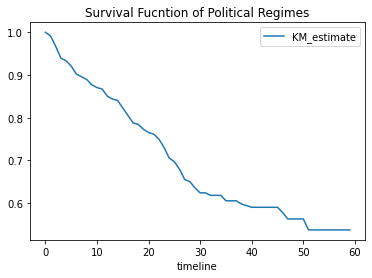

In [22]:
# curva de sobrevivência
fig, ax = plt.subplots()
ax = kmf.survival_function_.plot(ax = ax)
ax.set_title("Survival Fucntion of Political Regimes")
plt.show()

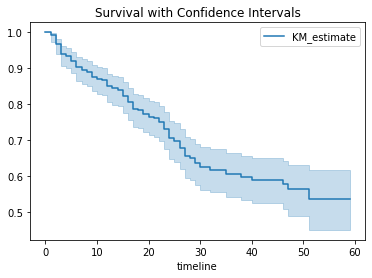

In [23]:
# curva de sobrevivência com intervalo de confiança
fig, ax = plt.subplots()
ax = kmf.plot(ax = ax)
ax.set_title("Survival with Confidence Intervals")
plt.show()

In [25]:
# modelo de risco proporcional de Cox (prevê a taxa de sobervivência)
cph = CoxPHFitter()

# preditoras
cph_bladder_df = bladder[["rx", "number", "size",
                         "enum", "stop", "event"]]

cph.fit(cph_bladder_df, duration_col = "stop", event_col = "event")

<lifelines.CoxPHFitter: fitted with 340 total observations, 228 right-censored observations>

In [26]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 340 total observations, 228 right-censored observations>
             duration col = 'stop'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 340
number of events observed = 112
   partial log-likelihood = -565.66
         time fit was run = 2022-08-24 16:41:01 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
rx         -0.60       0.55       0.20            -0.99            -0.20                 0.37                 0.82
number      0.22       1.24       0.05             0.13             0.31                 1.13                 1.36
size       -0.06       0.94       0.07            -0.20             0.08                 0.82                 1.09
enum       -0.60       0.55       0.09            -0.79            -0.42                 0.45                 0.66

            cmp to     z      p   -log2(p)
covariate                                 
rx            0.00 -2.97 <0.005       8.41
number        0.00  4.68 <0.005      18.38
size          0.00 -0.80   0.42       1.24
enum          0.00 -6.42 <0.005      32.80
---
Concordance = 0.75
Partial AIC = 1139.32
log-likelihood ratio test = 67.21 on 4 df
-log2(p) of ll-ratio test = 43.37

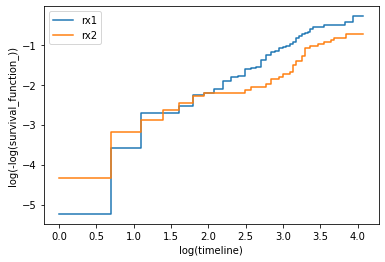

In [27]:
# testando os pressupostos de Cox

# plotando curvas de sobrevivência separadas por estratos
# se as curvas log(-log(survival curve)) e log(time) se cruzarem, é sinal de que o modelo precisa
# ser estratificado pela variável em questão
rx1 = bladder.loc[bladder["rx"] == 1]
rx2 = bladder.loc[bladder["rx"] == 2]

kmf1 = KaplanMeierFitter()
kmf1.fit(rx1["stop"], event_observed = rx1["event"])

kmf2 = KaplanMeierFitter()
kmf2.fit(rx2["stop"], event_observed = rx2["event"])

fig, axes = plt.subplots()

# coloca as duas plotagens nos mesmos eixos
kmf1.plot_loglogs(ax = axes)
kmf2.plot_loglogs(ax = axes)

axes.legend(["rx1", "rx2"])

plt.show()

In [30]:
# estratificando as análises, já que o pressuposto foi violado
cph_strat = CoxPHFitter()
cph_strat.fit(cph_bladder_df, duration_col = "stop", event_col = "event",
             strata = ["rx"])

cph_strat.print_summary()

<lifelines.CoxPHFitter: fitted with 340 total observations, 228 right-censored observations>
             duration col = 'stop'
                event col = 'event'
                   strata = ['rx']
      baseline estimation = breslow
   number of observations = 340
number of events observed = 112
   partial log-likelihood = -493.52
         time fit was run = 2022-08-24 16:44:50 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
number      0.21       1.24       0.05             0.12             0.30                 1.13                 1.36
size       -0.05       0.95       0.07            -0.19             0.08                 0.82                 1.09
enum       -0.61       0.55       0.09            -0.79            -0.42                 0.45                 0.66

            cmp to     z      p   -log2(p)
covariate                                 
number        0.00  4.60 <0.005      17.84
size          0.00 -0.77   0.44       1.19
enum          0.00 -6.45 <0.005      33.07
---
Concordance = 0.74
Partial AIC = 993.04
log-likelihood ratio test = 61.84 on 3 df
-log2(p) of ll-ratio test = 41.93